AttributeError: 'float' object has no attribute 'shape'

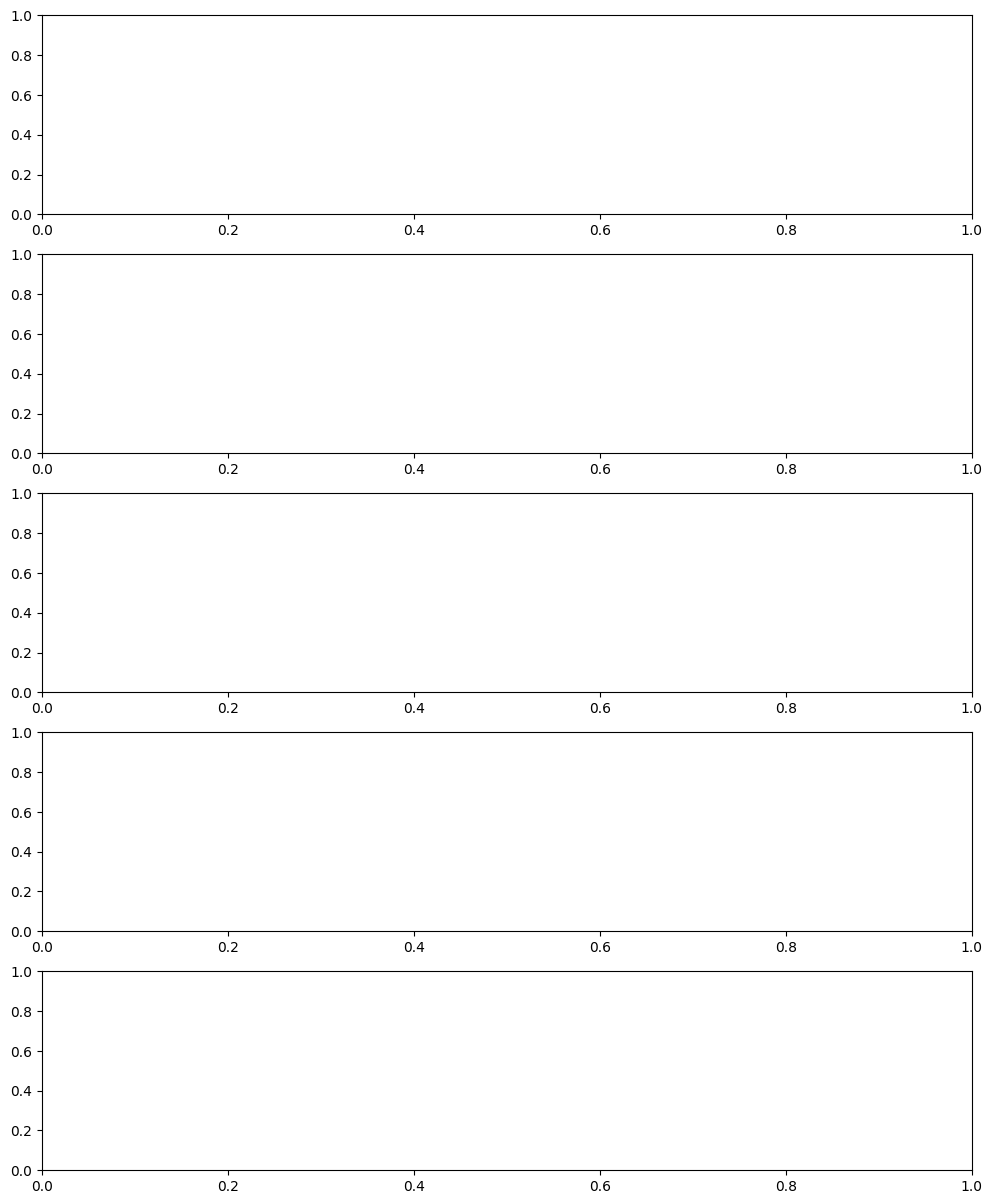

In [ ]:
from datasets import Audio, load_dataset
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

ds = load_dataset("DBD-research-group/BirdSet", "HSN", streaming=True)
ds = ds.cast_column("audio", Audio(sampling_rate=32_000))  # ensures decoding

test = ds["test"]

# Create figure for 5 samples
fig, axes = plt.subplots(5, 1, figsize=(12, 15))

# Process 5 examples
for i in range(5):
    ex = next(iter(test))
    wav = ex["audio"]["array"]            # np.float32 samples
    sr  = ex["audio"]["sampling_rate"]    # 32000
    
    start  = ex["start_time"]   # 32000
    end  = ex["end_time"]   # 32000
    
    print(f"Sample {i+1}: start={start}, end={end}, shape={wav.shape}")
    
    # Create spectrogram
    S = librosa.stft(wav, n_fft=1024, hop_length=64)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    
    # Plot spectrogram on subplot
    ax = axes[i]
    librosa.display.specshow(S_db, sr=sr, hop_length=64, x_axis='time', y_axis='hz', ax=ax)
    ax.set_title(f'Sample {i+1} Spectrogram')

plt.tight_layout()
plt.show()


In [3]:
from datasets import Audio, load_dataset
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
from collections import defaultdict
from matplotlib.patches import Rectangle

CFG = "HSN"
SR  = 32_000

# Streaming = True yields one row PER EVENT in the soundscape test split
ds = load_dataset("DBD-research-group/BirdSet", CFG, streaming=True, trust_remote_code=True)
ds = ds.cast_column("audio", Audio(sampling_rate=SR))
test = ds["test"]

# --- 1) iterate events correctly and print onset/offsets ---
it = iter(test)  # create ONE iterator
for i in range(5):
    ex = next(it)
    start_s = float(ex["start_time"])   # seconds
    end_s   = float(ex["end_time"])     # seconds
    low_hz  = int(ex["low_freq"])       # Hz (empirically)
    high_hz = int(ex["high_freq"])      # Hz
    print(f"{i+1}: {ex['filepath']}  start={start_s:.3f}s  end={end_s:.3f}s  "
          f"low={low_hz}Hz high={high_hz}Hz")

# --- 2) convert an event’s times to sample indices or frames ---
def to_samples(t_s):  # seconds -> sample index
    return int(round(t_s * SR))

# --- 3) visualize one event with its time–frequency box ---
ex = next(iter(test))  # take one event
wav = ex["audio"]["array"]; sr = ex["audio"]["sampling_rate"]
start_s, end_s = float(ex["start_time"]), float(ex["end_time"])
low_hz, high_hz = int(ex["low_freq"]), int(ex["high_freq"])

# STFT
hop = 64
S = librosa.stft(wav, n_fft=1024, hop_length=hop)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

plt.figure(figsize=(12, 4))
img = librosa.display.specshow(S_db, sr=sr, hop_length=hop, x_axis='time', y_axis='hz')
ax = plt.gca()

# draw the event time–frequency rectangle in data coordinates
width_s  = end_s - start_s
height_hz = max(0, high_hz - low_hz)
ax.add_patch(Rectangle((start_s, low_hz), width_s, height_hz, fill=False, linewidth=2))
ax.set_title("Event box on spectrogram")
plt.tight_layout()
plt.show()

# Optional crop around the event (e.g., +-0.5 s):
pad = 0.5
i0, i1 = max(0, to_samples(start_s - pad)), min(len(wav), to_samples(end_s + pad))
event_wav = wav[i0:i1]

# --- 4) gather ALL events for a single file (still streaming) ---
events_by_path = defaultdict(list)
for ex in test:
    events_by_path[ex["filepath"]].append(
        (float(ex["start_time"]), float(ex["end_time"]),
         int(ex["low_freq"]), int(ex["high_freq"]))
    )
    # stop once we collected enough for one file
    if len(events_by_path) and len(next(iter(events_by_path.values()))) >= 10:
        break

path, events = next(iter(events_by_path.items()))
print(f"{path} has {len(events)} test events. First 3:", events[:3])


1: HSN_001_20150708_061805.ogg  start=3.800s  end=4.000s  low=2272Hz high=6515Hz
2: HSN_001_20150708_061805.ogg  start=4.600s  end=4.800s  low=2939Hz high=6303Hz
3: HSN_001_20150708_061805.ogg  start=5.000s  end=5.200s  low=3424Hz high=4333Hz
4: HSN_001_20150708_061805.ogg  start=90.200s  end=91.500s  low=3212Hz high=5484Hz
5: HSN_001_20150708_061805.ogg  start=97.700s  end=98.900s  low=3242Hz high=5697Hz


KeyboardInterrupt: 

IndexError: index 10 is out of bounds for axis 0 with size 10

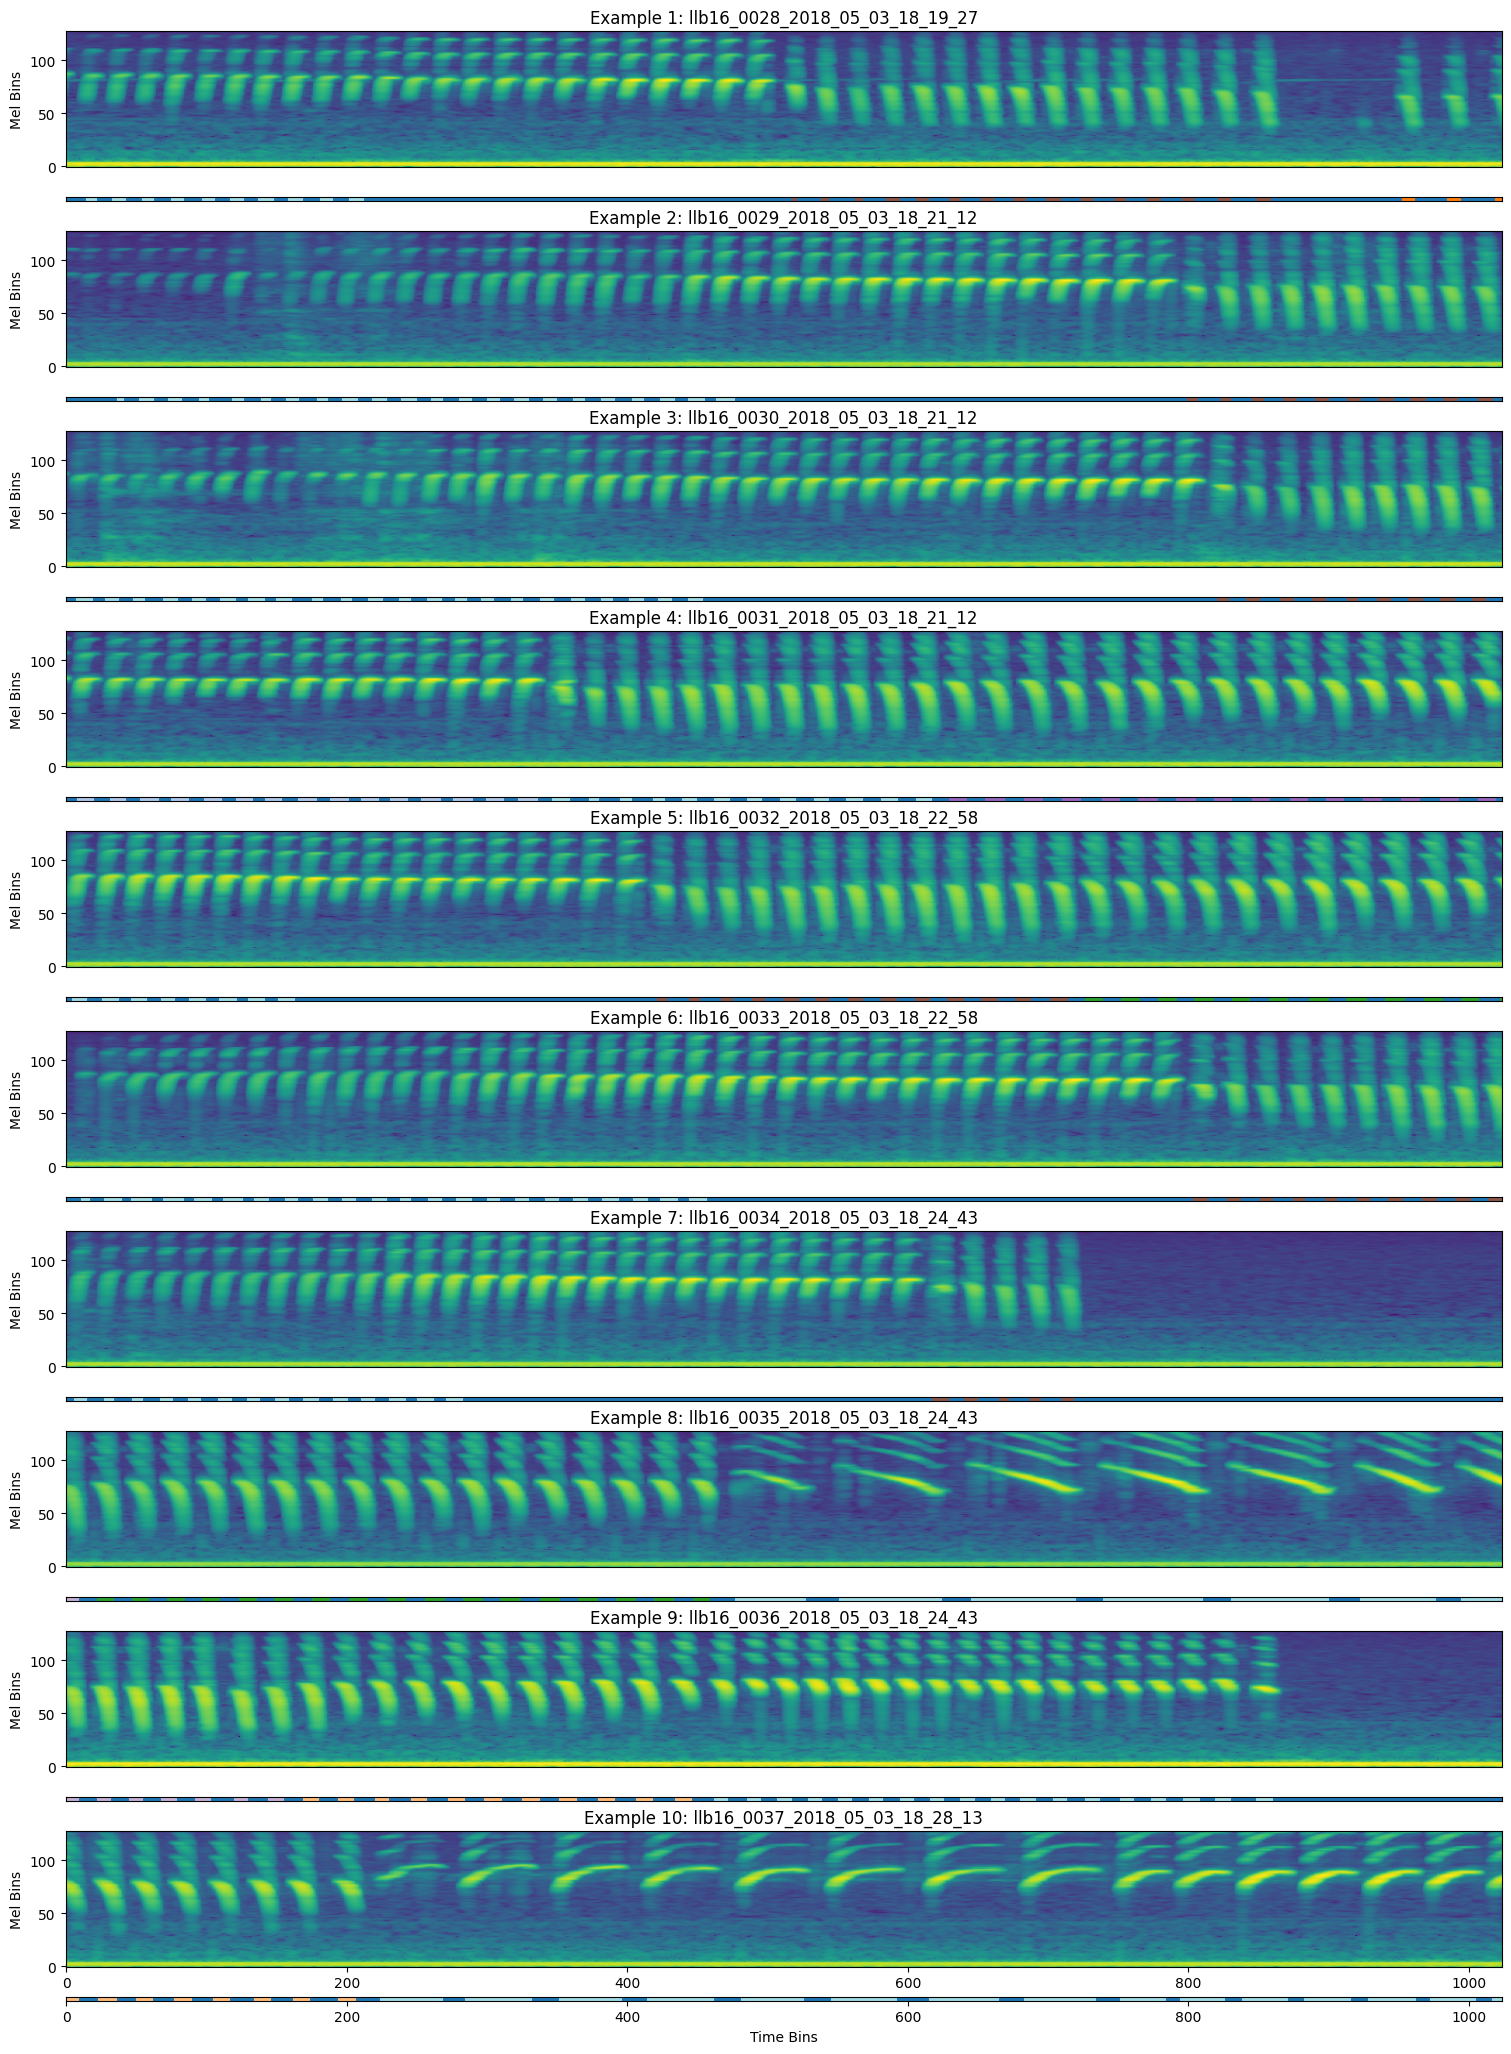

In [6]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Add the src directory to the Python path
sys.path.append('src')

# Now you can import the data_loader module
from data_loader import SupervisedSpectogramDataset 

t = SupervisedSpectogramDataset(dir="/media/george-vengrovski/disk2/specs/canary_64hop_32khz_test", annotation_file_path="/home/george-vengrovski/Documents/projects/TinyBird/files/canary_annotations.json", mode="classify")

# Create a figure with subplots for 10 examples
fig, axes = plt.subplots(10, 1, figsize=(15, 20), constrained_layout=True)

for i in range(55):
    spec, labels, filename = t[i]
    
    # Remove channel dimension for plotting
    spec_plot = spec.squeeze(0).numpy()
    labels_plot = labels.numpy() + 1
    
    # Create subplot
    ax = axes[i]
    
    # Plot spectrogram
    im = ax.imshow(spec_plot, aspect='auto', origin='lower', cmap='viridis')
    ax.set_title(f'Example {i+1}: {filename}')
    ax.set_ylabel('Mel Bins')
    
    # Create a colorbar for labels below the spectrogram
    # Normalize labels to [0, 1] range for colormap, ensuring max 30 unique labels
    unique_labels = np.unique(labels_plot)
    if len(unique_labels) > 1:
        # Cap the number of unique labels at 30
        max_label_value = min(29, labels_plot.max())  # 0-29 gives us 30 unique values
        labels_capped = np.clip(labels_plot, labels_plot.min(), max_label_value)
        labels_normalized = (labels_capped - labels_capped.min()) / max(1, (labels_capped.max() - labels_capped.min()))
    else:
        labels_normalized = labels_plot
    
    # Create a thin horizontal bar to show labels
    label_bar = labels_normalized.reshape(1, -1)
    
    # Append a perfectly aligned 1-row label bar under this spectrogram
    divider = make_axes_locatable(ax)
    label_ax = divider.append_axes("bottom", size="3%", pad=0.3, sharex=ax)
    label_ax.imshow(label_bar, aspect='auto', cmap='tab20', vmin=0, vmax=1, interpolation='nearest')
    label_ax.set_ylim(0, 1)
    label_ax.set_yticks([])
    if i != 9:
        label_ax.set_xticks([])
    else:
        label_ax.set_xlabel('Time Bins')

plt.show()

print(f"Spectrogram shape: {spec.shape}")
print(f"Labels shape: {labels.shape}")